In [12]:
using Revise
using SSMCMain, SSMCMain.MinimalModelSemisymbolic

using Base.Threads

using Symbolics
import Nemo

using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase

In [13]:
using GLMakie
using CairoMakie
CairoMakie.activate!()
# GLMakie.activate!(; px_per_unit=1.)
# display(GLMakie.Screen(), f.figure)
ENV["COLUMNS"] = 280

280

# Loading pscan data

In [14]:
data = jldopen("../cluster_env/runs/mmsa_pscan4/out.jld2");
params_mlKcd = [data[x] for x in ["m", "l", "K", "c", "d"]];
params_Ds = [data[x] for x in ["DN", "DG", "DR"]];
df = data["df"];

In [15]:
function get_random_row(df)
    df[rand(1:nrow(df)),:]
end
function df_correlations(df)
    NamedArray(cor(Matrix(df)), (names(df), names(df)))
end
function df_row_to_mmp(dfrow)
    MinimalModelParamsSpace(
        dfrow.m, dfrow.l, dfrow.K, dfrow.c, dfrow.d,
        dfrow.DN, dfrow.DG, dfrow.DR
    )
end

df_row_to_mmp (generic function with 1 method)

# Basics and plots

In [61]:
get_random_row(df)

Row,m,l,K,c,d,DN,DG,DR,numss,nummodes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
25909208,0.13313,1.0,32.0,0.5,0.015625,0.000615848,23357.2,3.79269,1,1


In [44]:
@show nrow(df)
describe(df)

nrow(df) = 35549363


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,0.600095,0.0078125,0.13313,4.0,0,Float64
2,l,0.684391,0.1,0.8,1.0,0,Float64
3,K,7.98094,0.0625,3.31101,32.0,0,Float64
4,c,3.93858,0.0078125,1.0,16.0,0,Float64
5,d,2.20906,0.0078125,0.25,16.0,0,Float64
6,DN,1.24253,1.0e-7,7.8476e-6,23357.2,0,Float64
7,DG,26121.3,4.28133e-7,5455.59,100000.0,0,Float64
8,DR,808.702,1.0e-7,0.00263665,100000.0,0,Float64
9,numss,1.00052,1,1.0,2,0,Int64


In [52]:
df_correlations(df)

10×10 Named Matrix{Float64}
   A ╲ B │           m            l            K            c            d           DN           DG           DR        numss     nummodes
─────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
m        │         1.0   -0.0869344     0.281271     0.207818     0.128607    0.0331171   -0.0479592   -0.0077613  -0.00873762  -0.00959229
l        │  -0.0869344          1.0    0.0656026    0.0217909    0.0535051    0.0100065   -0.0394849    0.0894044   -0.0138949    0.0207966
K        │    0.281271    0.0656026          1.0    -0.178771   -0.0952093   0.00315202   0.00791437   0.00570736   -0.0141443  -0.00834499
c        │    0.207818    0.0217909    -0.178771          1.0    0.0386115   0.00317588   0.00393193   -0.0306911   -0.0160782   -0.0307907
d        │    0.128607    0.0535051   -0.0952093    0.0386115          1.0  0.000171014     0.017351     0.032099  -0.00588844    0.

#### One dim freqs

In [203]:
xx = freqtable(df, :DN)

5-element Named Vector{Int64}
DN          │ 
────────────┼──────
1.0e-5      │ 26763
0.000398107 │ 13880
0.0158489   │  3921
0.630957    │   539
25.1189     │     6

In [218]:
barplot(10 .^ (1:5), collect(xx); axis=(; xscale=log10))

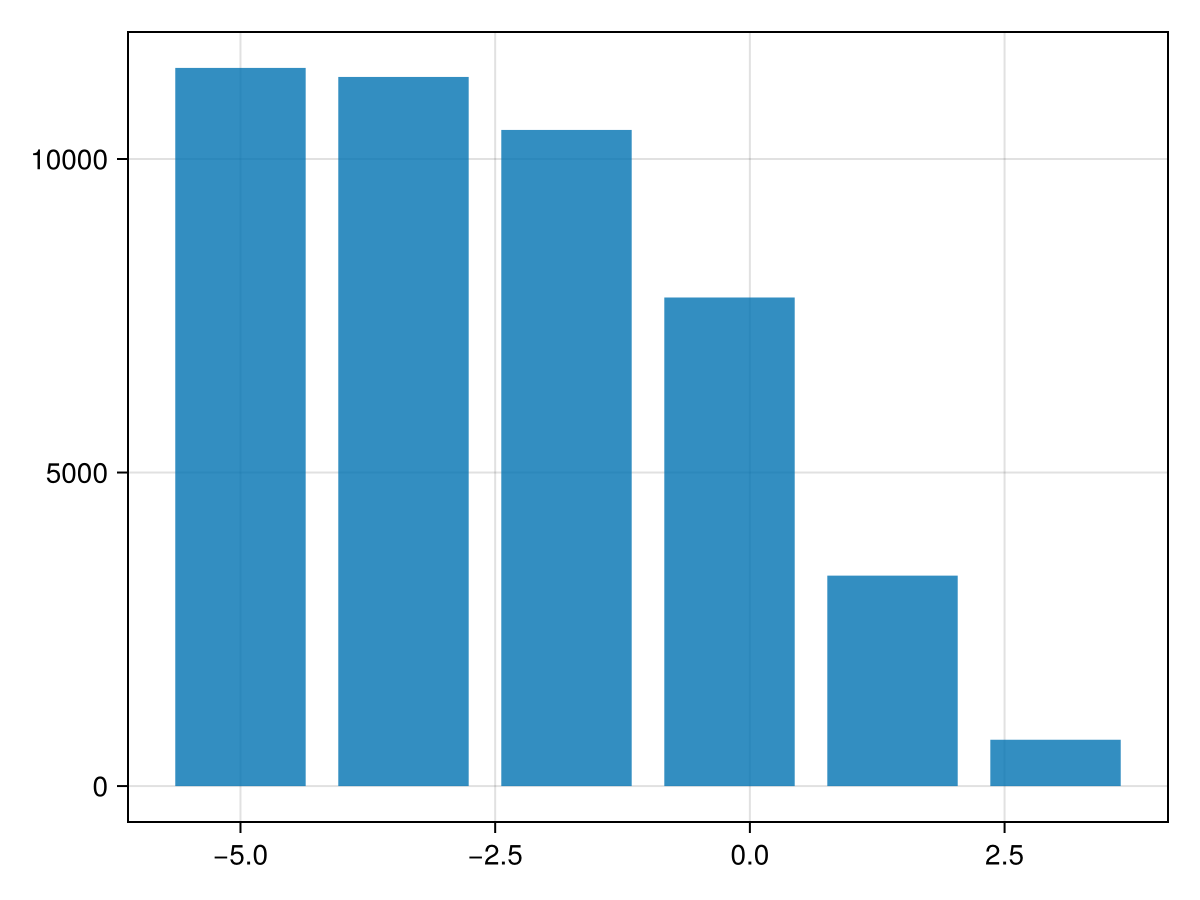

In [225]:
xx = freqtable(df, :DR)
# barplot(names(xx, 1), collect(xx))
faa = barplot(log10.(names(xx, 1)), collect(xx))

#### Two dim freqs

5×6 Named Matrix{Int64}
    DG ╲ DR │      1.0e-5  0.000398107    0.0158489     0.630957      25.1189       1000.0
────────────┼─────────────────────────────────────────────────────────────────────────────
0.000398107 │           1            1            0            0            0            0
0.0158489   │         111           82            8            2            0            0
0.630957    │         893          809          479           60            8            2
25.1189     │        3395         3366         2959         1509          256           55
1000.0      │        7052         7050         7017         6220         3092          682

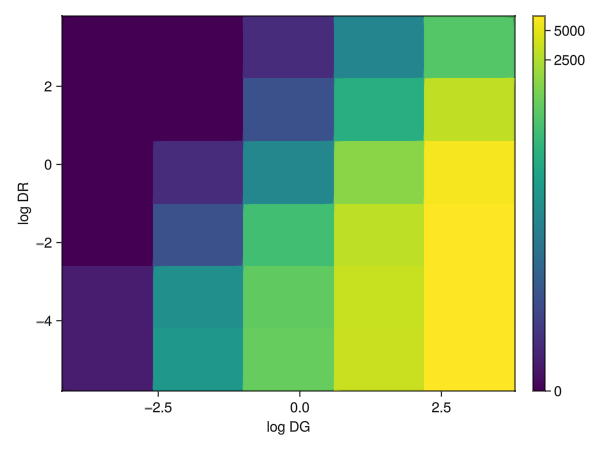

In [40]:
xx = freqtable(df, :DG, :DR)
display(xx)

xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[1])), 1)
setnames!(xx, log10.(names(xx, 1)), 1)
xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[2])), 2)
setnames!(xx, log10.(names(xx, 2)), 2)

fap = heatmap(names(xx, 1), names(xx, 2), xx; colorscale=Makie.pseudolog10)
Colorbar(fap.figure[1,2], fap.plot)

fap.axis.xlabel = string(dimnames(xx, 1))
fap.axis.ylabel = string(dimnames(xx, 2))

fap

#### Three dim freqs

In [93]:
yy = freqtable(df, :DR, :DG, :DR);

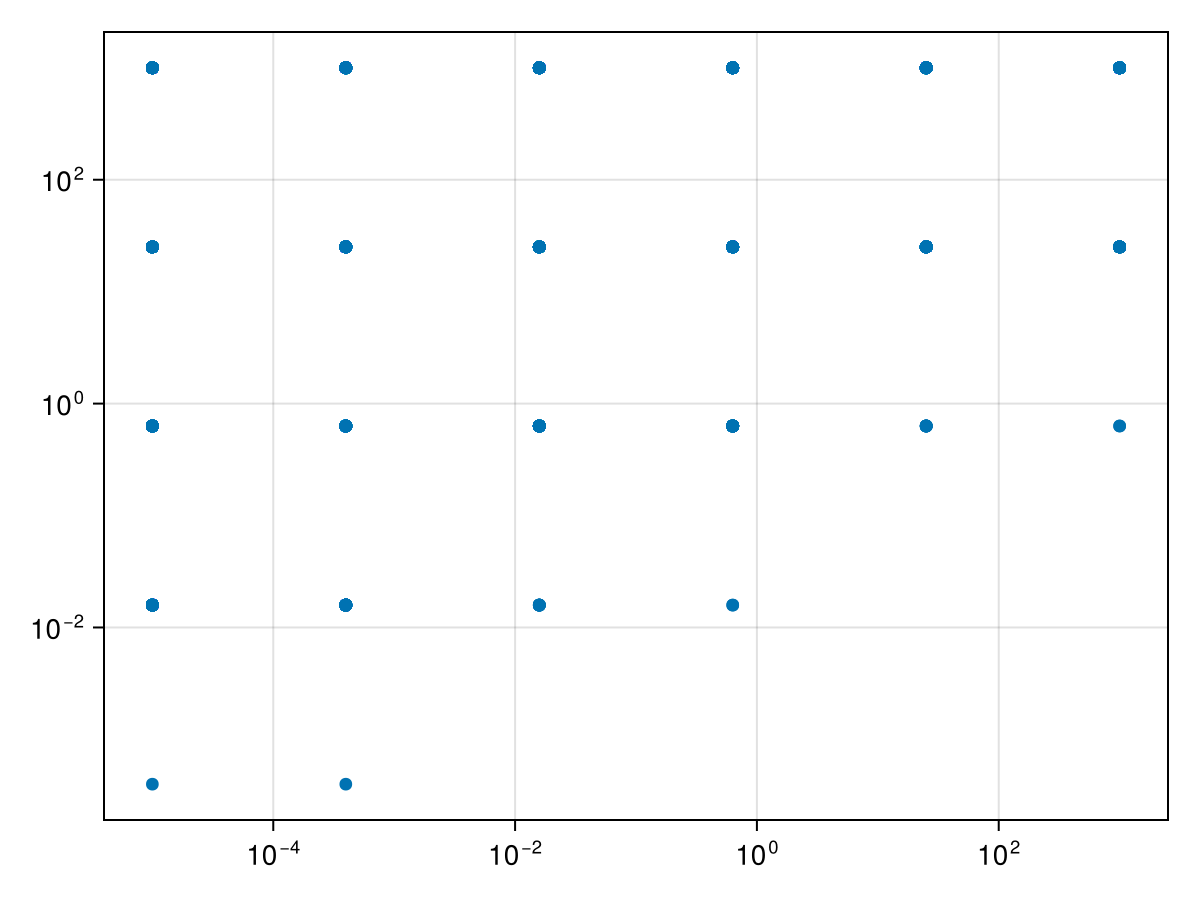

In [10]:
scatter(df.DR, df.DG; axis=(; yscale=log10, xscale=log10))

# Do we ever get multiple instabilities?

In [16]:
non1df = df[df.nummodes .!= 1,:];
@show nrow(non1df)
# df = non1df;

nrow(non1df) = 212372


212372

In [17]:
get_random_row(non1df)

Row,m,l,K,c,d,DN,DG,DR,numss,nummodes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
125777,0.413877,0.5,0.0625,16.0,8.0,16.2378,100000.0,297.635,1,2


# Looking at a single system

In [347]:
mmpf = df_row_to_mmp(get_random_row(df));

In [348]:
# mmpf = MinimalModelParamsSpace(0.1, 0., 10., 0.01, 0.01, 1e-5, 0.01584893192461114, 0.00039810717055349735);
# mmpf = MinimalModelParamsSpace(fi_to_fparams(fi_to_run)...)
mmicrm_params = mmp_to_mmicrm(mmpf);
mmpf

MinimalModelParamsSpace{Float64}(2.268625044390925, 0.5, 10.293319184075456, 4.000000000000001, 0.0625, 3.359818286283781e-5, 16.237767391887225, 0.04832930238571742)

In [349]:
xx = analyze_single_mmps(mmpf; include_extinct=true, threshold=1e-12)
println((xx[1], xx[2]))
print("sss: ")
show(xx[3])
println()
print("kroots fe ss: ")
show(xx[4])
println()
print("nummodes fe ss fe segment: ")
show(xx[5])

(1, 1)
sss: [[2.3042088673131564, 1.007486047421729, 4.058447192759456]]
kroots fe ss: [[2.5755529047994923, 18.27810109042985]]
nummodes fe ss fe segment: [[0, 1, 0]]

In [350]:
# choose a ss for lisntab etc.
nsol = xx[3][1]

3-element Vector{Float64}:
 2.3042088673131564
 1.007486047421729
 4.058447192759456

## Numerics

#### No space solver

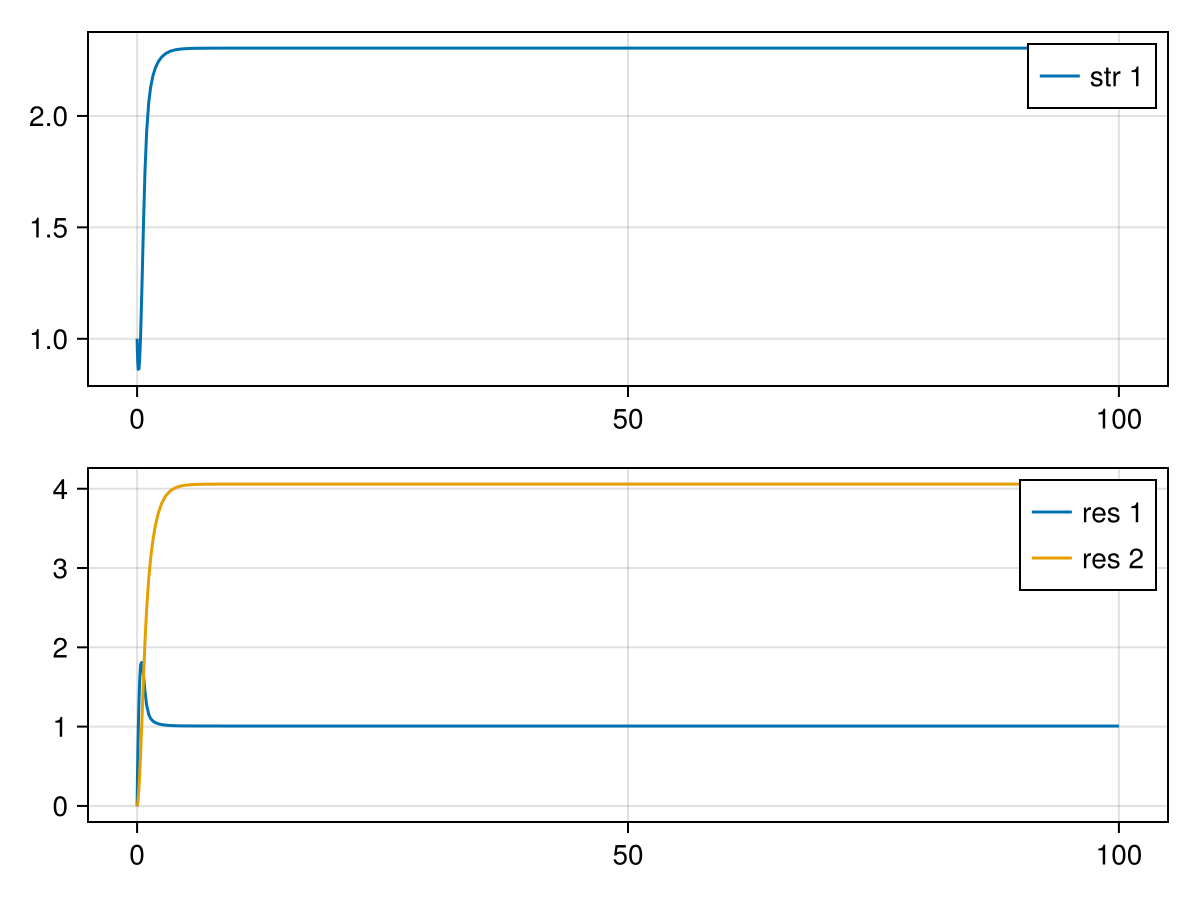

3-element Vector{Float64}:
 2.304208867087843
 1.0074860475933782
 4.058447191685223

In [352]:
u0 = make_mmicrmu0_smart(mmicrm_params; u0=:onlyN)
# u0 = [10., 0., 0.]
# u0 = nssol .* (1 .+ 10. .* (rand(3) .- 0.5))
nsp = ODEProblem(mmicrmfunc!, u0, (0, 100), mmicrm_params)

check_mmicrmparams(nsp.p)
s = solve(nsp)
display(plot_mmicrm_sol(s))
s.u[end]

#### Linstab

mrl = -0.026021983012113198


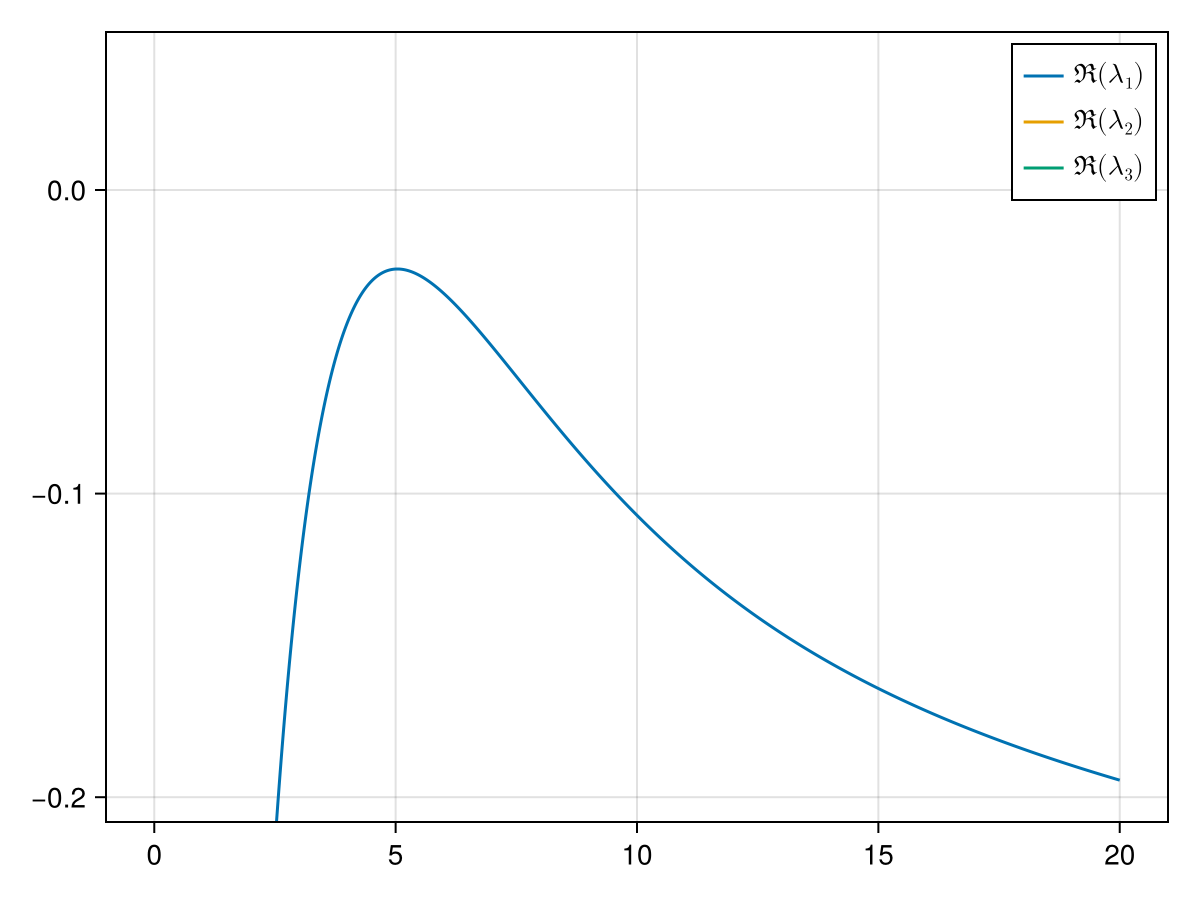

In [355]:
ks = LinRange(0., 20, 10000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, mmicrm_params, Ds, nssol);
mrl = maximum(real(lambdas))
@show mrl
faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-8*abs(mrl), 2*abs(mrl)))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [356]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(mmicrm_params, nssol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.8210919687786723
  0.007502844588707922
 -0.5707466041337798

### 1D PDE sim

In [369]:
ssize = (2000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform(get_Ns(mmicrm_params)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.005, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1e6, mmicrm_params, get_Ds(mmpf), space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 2000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.005]))

In [370]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  1.638560 seconds (310.10 k allocations: 526.841 MiB, 31.26% gc time)
Success
nf is 1243
solution has 230 saved states
max resid is 1.09131e-09


┌ Warning: reaching negative values, minimum is -9.9841e-08
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


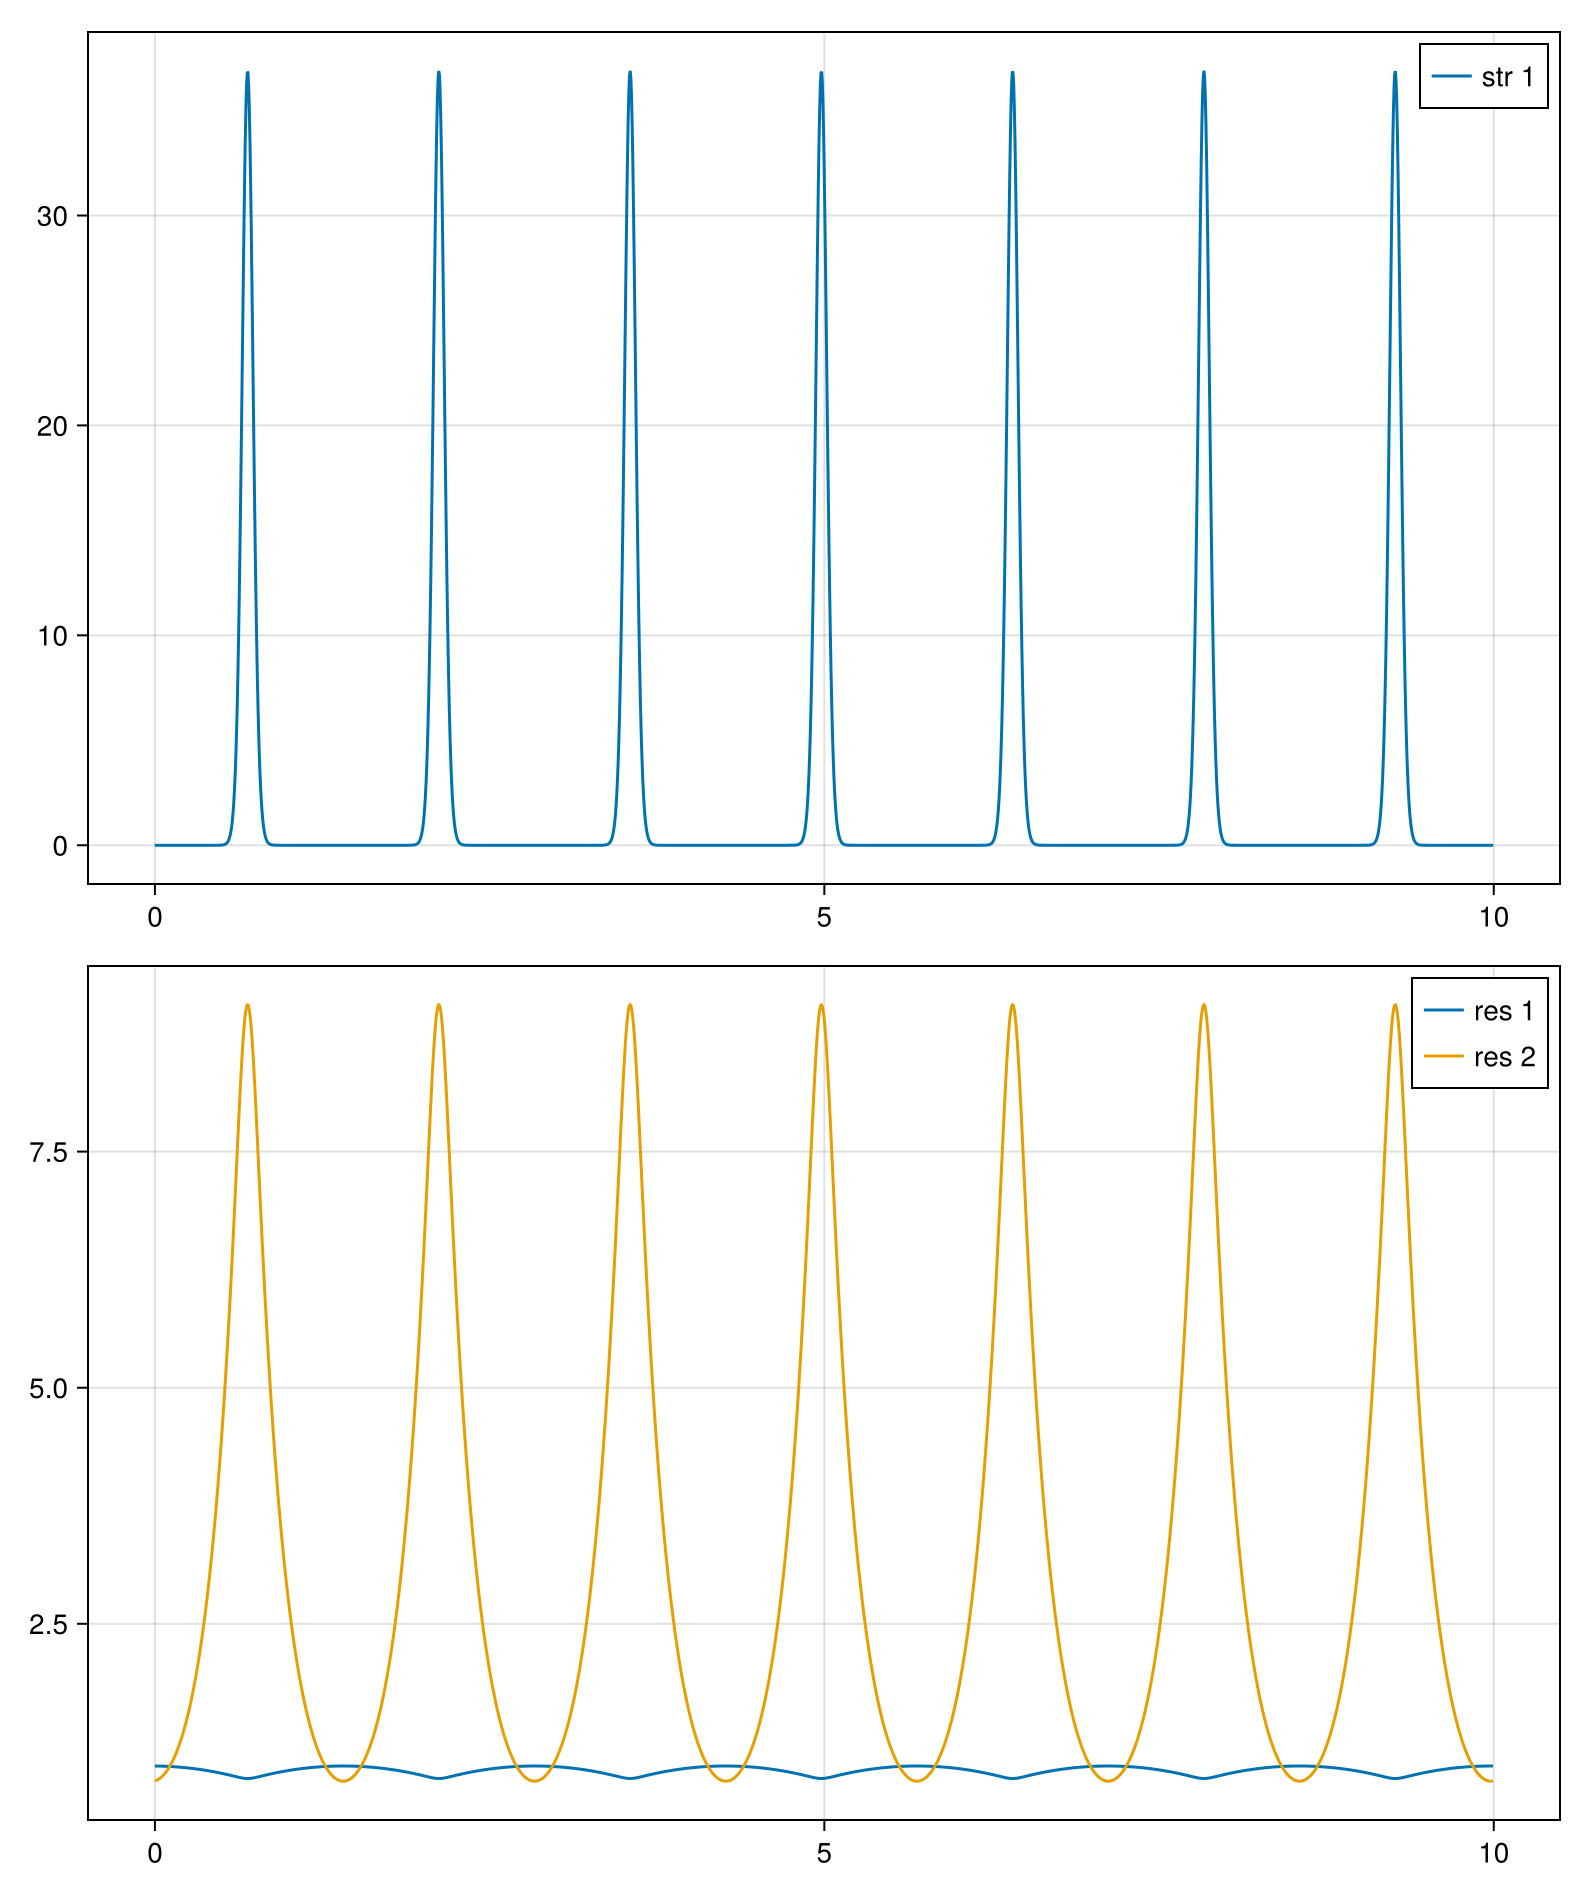

In [376]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))
display(GLMakie.Screen(), faa.figure)
faa

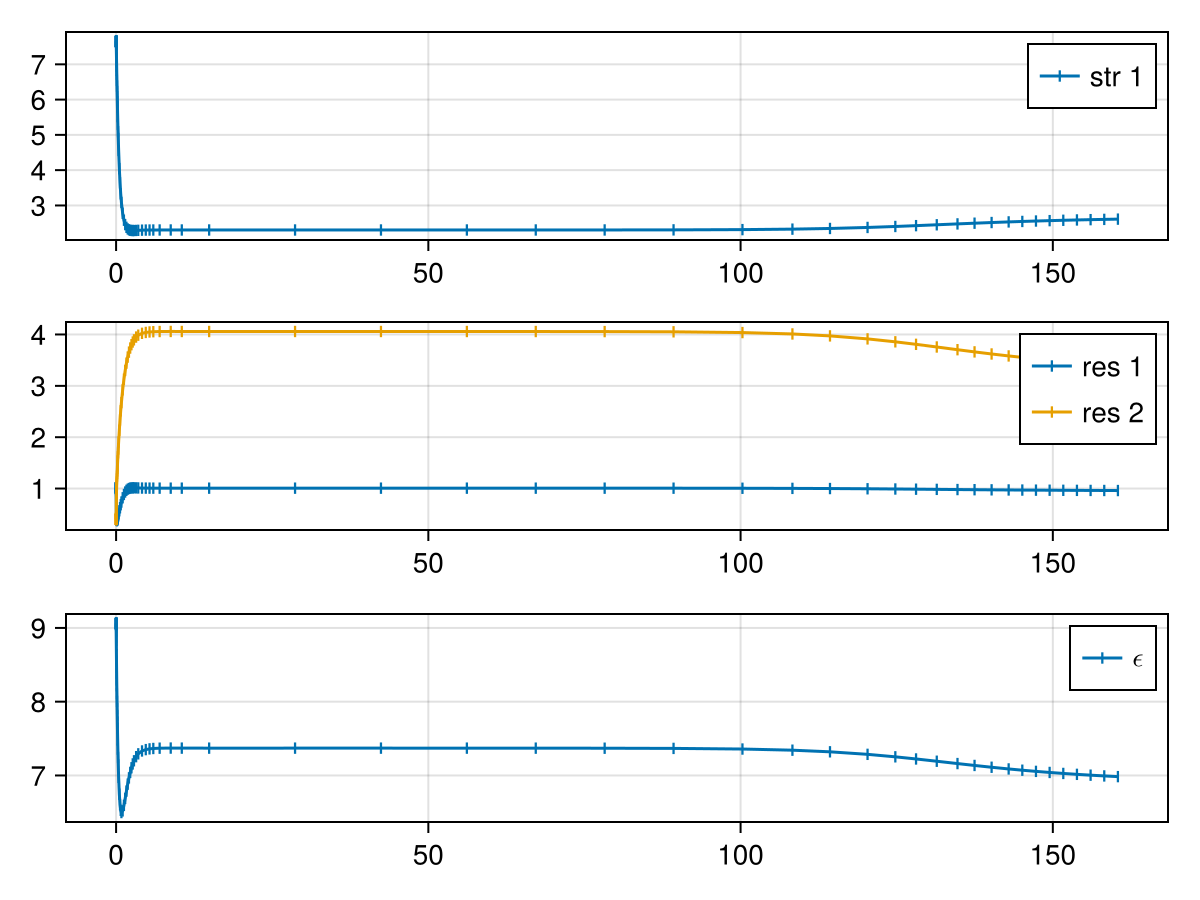

In [384]:
f = plot_smmicrm_sol_avgs(sps, 1:120; plote=true)
# display(GLMakie.Screen(), f)